In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import timezone
import pickle as pkl
import tldextract




In [3]:

train_df = pd.read_csv('train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('test_sessions.csv',
                      index_col='session_id')


train_df.shape, test_df.shape



# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

#full_df[:].fillna(method='bfill',inplace=True)

# Index to split the training and test data sets
idx_split = train_df.shape[0]

full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
100044,52,2013-03-12 10:28:58,52.0,2013-03-12 10:29:00,52.0,2013-03-12 10:29:01,23.0,2013-03-12 10:29:02,52.0,2013-03-12 10:29:03,...,2013-03-12 10:29:08,23.0,2013-03-12 10:29:09,52.0,2013-03-12 10:29:10,23.0,2013-03-12 10:29:35,343.0,2013-03-12 10:29:35,0
51934,786,2014-03-31 10:31:48,786.0,2014-03-31 10:31:49,786.0,2014-03-31 10:31:50,786.0,2014-03-31 10:31:51,782.0,2014-03-31 10:31:54,...,2014-03-31 10:32:08,786.0,2014-03-31 10:32:16,786.0,2014-03-31 10:32:20,786.0,2014-03-31 10:32:21,782.0,2014-03-31 10:32:24,0
174046,5828,2014-01-27 08:09:31,5828.0,2014-01-27 08:09:32,5828.0,2014-01-27 08:09:33,5828.0,2014-01-27 08:09:34,5828.0,2014-01-27 08:09:35,...,2014-01-27 08:09:36,5828.0,2014-01-27 08:09:38,5828.0,2014-01-27 08:09:40,5828.0,2014-01-27 08:09:41,23.0,2014-01-27 08:09:43,0
247157,152,2014-02-26 09:27:56,167.0,2014-02-26 09:33:20,167.0,2014-02-26 09:33:22,21.0,2014-02-26 09:33:22,384.0,2014-02-26 09:33:22,...,2014-02-26 09:33:22,21.0,2014-02-26 09:33:55,21.0,2014-02-26 09:34:32,270.0,2014-02-26 09:40:53,167.0,2014-02-26 09:40:54,0
120439,478,2014-04-14 11:13:50,2750.0,2014-04-14 11:13:51,478.0,2014-04-14 11:13:51,464.0,2014-04-14 11:13:51,2750.0,2014-04-14 11:13:52,...,2014-04-14 11:14:21,2739.0,2014-04-14 11:14:22,2612.0,2014-04-14 11:14:22,2738.0,2014-04-14 11:14:22,2740.0,2014-04-14 11:14:22,0


In [4]:
full_df = train_df.sample(1000)


0    996
1      4
Name: target, dtype: int64


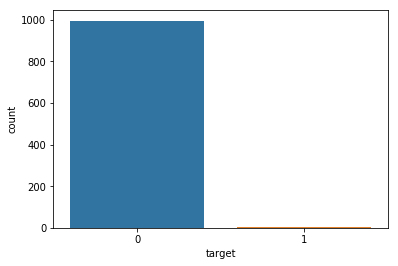

In [6]:
sns.countplot(full_df['target']) #Imbalanced Dataset
print(full_df.target.value_counts())

In [7]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
full_df[times] = full_df[times].apply(pd.to_datetime)


# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
full_df[sites] = full_df[sites].fillna(0).astype('int')

# Load websites dictionary
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pkl.load(input_file)

site_dict = {y:x for x,y in site_dict.items()}
site_dict[0] = 'None'



# Create dataframe for the dictionary
#sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
#print(u'Websites total:', sites_dict.shape[0])

In [8]:
# Dataframe for new features
full_df_feat = pd.DataFrame(index=full_df.index)

# Add time features
full_df_feat['month'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month)
full_df_feat['day'] = full_df['time1'].apply(lambda ts: ts.day)
full_df_feat['dow'] = full_df['time1'].apply(lambda x: x.date().weekday())
full_df_feat['count'] = full_df[times].apply(lambda x: x.nunique(), axis=1)
full_df_feat.head()

,month,day,dow,count
session_id,,,,
183530,201311,21,3,10
117341,201403,28,4,7
102142,201311,18,0,8
223002,201403,17,0,5
66195,201311,25,0,6


In [9]:
for t in times:
    col = 'hour' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.hour)
    
    col = 'minute' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.minute)
    
    col = 'second' + t.replace('time','')
    full_df_feat[col] = full_df[t].apply(lambda ts: ts.second)

    
full_df_feat.head()

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,second7,hour8,minute8,second8,hour9,minute9,second9,hour10,minute10,second10
session_id,,,,,,,,,,,,,,,,,,,,,
183530,201311,21,3,10,9,58,3,9.0,58.0,20.0,...,50.0,10.0,0.0,3.0,10.0,0.0,20.0,10.0,0.0,43.0
117341,201403,28,4,7,15,54,34,15.0,54.0,35.0,...,39.0,15.0,55.0,5.0,15.0,56.0,30.0,15.0,56.0,32.0
102142,201311,18,0,8,15,12,38,15.0,12.0,38.0,...,42.0,15.0,16.0,54.0,15.0,17.0,0.0,15.0,17.0,3.0
223002,201403,17,0,5,13,11,9,13.0,11.0,9.0,...,10.0,13.0,11.0,11.0,13.0,11.0,18.0,13.0,11.0,25.0
66195,201311,25,0,6,19,55,11,19.0,55.0,14.0,...,28.0,19.0,55.0,28.0,19.0,55.0,29.0,19.0,55.0,29.0


In [10]:
time_df = pd.DataFrame(index=full_df.index)

# Find sessions' starting and ending
time_df['min'] = full_df[times].min(axis=1)
time_df['max'] = full_df[times].max(axis=1)


# Calculate sessions' duration in seconds
full_df_feat['duration'] = (time_df['max'] - time_df['min']) / np.timedelta64(1, 's')

full_df_feat.head(20)

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,hour8,minute8,second8,hour9,minute9,second9,hour10,minute10,second10,duration
session_id,,,,,,,,,,,,,,,,,,,,,
183530,201311,21,3,10,9,58,3,9.0,58.0,20.0,...,10.0,0.0,3.0,10.0,0.0,20.0,10.0,0.0,43.0,160.0
117341,201403,28,4,7,15,54,34,15.0,54.0,35.0,...,15.0,55.0,5.0,15.0,56.0,30.0,15.0,56.0,32.0,118.0
102142,201311,18,0,8,15,12,38,15.0,12.0,38.0,...,15.0,16.0,54.0,15.0,17.0,0.0,15.0,17.0,3.0,265.0
223002,201403,17,0,5,13,11,9,13.0,11.0,9.0,...,13.0,11.0,11.0,13.0,11.0,18.0,13.0,11.0,25.0,16.0
66195,201311,25,0,6,19,55,11,19.0,55.0,14.0,...,19.0,55.0,28.0,19.0,55.0,29.0,19.0,55.0,29.0,18.0
29687,201402,19,2,7,8,49,39,8.0,49.0,53.0,...,9.0,2.0,15.0,9.0,2.0,16.0,9.0,2.0,16.0,757.0
32066,201311,21,3,7,13,19,25,13.0,19.0,26.0,...,13.0,19.0,37.0,13.0,19.0,38.0,13.0,19.0,38.0,13.0
225427,201309,12,3,10,11,9,37,11.0,9.0,43.0,...,11.0,32.0,33.0,11.0,32.0,34.0,11.0,32.0,53.0,1396.0
210736,201404,14,0,8,15,17,47,15.0,17.0,49.0,...,15.0,18.0,12.0,15.0,18.0,12.0,15.0,18.0,13.0,26.0


In [11]:
def url_extract(url):
    try:
        return tldextract.extract(url)
    except:
        return None


for col in sites:
    name = 'subdomain' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[0])
    
    name = 'domain' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[1])  

    name = 'suffix' + col.replace('site','')
    full_df_feat[name] = full_df[col].apply(lambda row: url_extract(site_dict[row])[2])





full_df_feat.head()

,month,day,dow,count,hour1,minute1,second1,hour2,minute2,second2,...,suffix7,subdomain8,domain8,suffix8,subdomain9,domain9,suffix9,subdomain10,domain10,suffix10
session_id,,,,,,,,,,,,,,,,,,,,,
183530,201311,21,3,10,9,58,3,9.0,58.0,20.0,...,com,s,youtube,com,s,youtube,com,s,youtube,com
117341,201403,28,4,7,15,54,34,15.0,54.0,35.0,...,com,,twitter,com,s-static.ak,facebook,com,platform,twitter,com
102142,201311,18,0,8,15,12,38,15.0,12.0,38.0,...,com,h,live,com,dub111.mail,live,com,cid-dd6c19866ed2edd5.users.storage,live,com
223002,201403,17,0,5,13,11,9,13.0,11.0,9.0,...,ru,dmg,digitaltarget,ru,pool,datamind,ru,pool,datamind,ru
66195,201311,25,0,6,19,55,11,19.0,55.0,14.0,...,com,ocsp,digicert,com,ocsp,digicert,com,evssl-ocsp,geotrust,com


In [12]:
for i in range(1, 11):
    col0 = 'time%s'% str(i-1)
    col1 = 'time%s'% i
    name = 'duration%s'% i
    try:
        full_df_feat[name] = (full_df[col1] - full_df[col0]).apply(lambda row: row / np.timedelta64(1, 's'))
    except:
        full_df_feat[name] = 0

print(full_df_feat.head())

             month  day  dow  count  hour1  minute1  second1  hour2  minute2  \
session_id                                                                     
183530      201311   21    3     10      9       58        3    9.0     58.0   
117341      201403   28    4      7     15       54       34   15.0     54.0   
102142      201311   18    0      8     15       12       38   15.0     12.0   
223002      201403   17    0      5     13       11        9   13.0     11.0   
66195       201311   25    0      6     19       55       11   19.0     55.0   

            second2     ...      duration1  duration2  duration3  duration4  \
session_id              ...                                                   
183530         20.0     ...              0       17.0       23.0        7.0   
117341         35.0     ...              0        1.0        0.0        0.0   
102142         38.0     ...              0        0.0       75.0       45.0   
223002          9.0     ...              0  

In [13]:
categorials = ['month', 'day', 'dow', 'hour1', 'minute1', 'second1', 'hour2',
    'minute2', 'second2', 'hour3', 'minute3', 'second3', 'hour4', 'minute4',
    'second4', 'hour5', 'minute5', 'second5', 'hour6', 'minute6', 'second6',
    'hour7', 'minute7', 'second7', 'hour8', 'minute8', 'second8', 'hour9',
    'minute9', 'second9', 'hour10', 'minute10', 'second10',
    'subdomain1', 'domain1', 'suffix1', 'subdomain2', 'domain2', 'suffix2',
    'subdomain3', 'domain3', 'suffix3', 'subdomain4', 'domain4', 'suffix4',
    'subdomain5', 'domain5', 'suffix5', 'subdomain6', 'domain6', 'suffix6',
    'subdomain7', 'domain7', 'suffix7', 'subdomain8', 'domain8', 'suffix8',
    'subdomain9', 'domain9', 'suffix9', 'subdomain10', 'domain10',
    'suffix10']

for col in categorials:
    full_df_feat[col] = pd.Categorical(full_df_feat[col])